## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 44.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=114ee7e4c8956cd4f48d177ace5630375088461bb7b038e949534b23c88cd43e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 5.2 MB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 

The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

--2022-03-07 03:38:46--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.235.113
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.235.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 03:38:47 (129 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 03:38:47--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.235.113
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.235.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [application/json]
Saving to: ‘us-congress-tweets/tweets-s

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
print("Number of congress members tracked:", congress_members.count())

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [6]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [7]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [8]:
# your code here for unique users
tweets.show()
tweets.createOrReplaceTempView("tweet")


df1 = spark.sql("SELECT count(distinct user_id) as distinct_user_id_count FROM tweet")
print("The number of unique users are- ")
df1.show()

+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|                text|                 id|in_reply_to_user_id|in_reply_to_status_id|         created_at|                user|            entities|    retweeted_status|            user_id|
+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|RT @maddow: "I he...|1047999818038050816|               null|                 null|2018-10-05 00:00:02|{2017-03-22 03:11...|{[], [{16129920, ...|{1047941326975766...| 844386122822119424|
|@ChuckGrassley @S...|1047999818579292160|           10615232|                 null|2018-10-05 00:00:02|{2016-01-29 01:49...|{[], [{10615232, ...|                null|         4828166688|
|RT @cm_merlin: @f...|1048000082237247488|               nul

b) How many times is the user **GOPLeader** mentioned?


In [9]:
# your code here for unique users
from pyspark.sql.functions import explode
tweets.select(tweets.id.alias("id"),explode(tweets.entities.user_mentions.screen_name).alias("mentioned_names")).createOrReplaceTempView("AB")
df2 = spark.sql("SELECT count(distinct id) as GOPLEADER_count FROM AB GROUP BY mentioned_names HAVING mentioned_names ='GOPLeader' ")
print("The times user GOPLeader mentioned is :-")
df2.show()


The times user GOPLeader mentioned is :-
+---------------+
|GOPLEADER_count|
+---------------+
|           4728|
+---------------+



c) Now find the top-5 most mentioned members of Congress.

In [10]:
# code here
from pyspark.sql.functions import explode
import pandas 



df3 = tweets.select(tweets.id.alias("userid"),explode(tweets.entities.user_mentions.screen_name).alias("screen_name")).groupBy("screen_name").count().orderBy("count",ascending=False)

temp1 = congress_members.toPandas().drop('userid',axis = 1)
temp2 = df3.toPandas().drop('count',axis = 1)


index1 = pd.Index(temp1['screen_name'])
index2 = pd.Index(temp2['screen_name'])




print("Top-5 most mentioned members of Congress are:-")
values = index2.intersection(index1)[0:5]
for i in range (5):
  df3[df3.screen_name == values[i]].show()
  





Top-5 most mentioned members of Congress are:-
+------------+-----+
| screen_name|count|
+------------+-----+
|senatemajldr|15021|
+------------+-----+

+---------------+-----+
|    screen_name|count|
+---------------+-----+
|LindseyGrahamSC|14412|
+---------------+-----+

+-----------+-----+
|screen_name|count|
+-----------+-----+
| SenSchumer|13738|
+-----------+-----+

+-------------+-----+
|  screen_name|count|
+-------------+-----+
|RepAdamSchiff|13288|
+-------------+-----+

+-----------+-----+
|screen_name|count|
+-----------+-----+
| marcorubio| 9957|
+-----------+-----+



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [11]:
# code here
from pyspark.sql.functions import explode
from pyspark.sql.functions import month
from pyspark.sql.window import Window
from pyspark.sql.functions import rank,col

df4 = tweets.select(tweets.created_at.alias("time"),explode(tweets.entities.user_mentions.screen_name).alias("mentioned_names"))
df5 = df4.withColumn('month',month(df4.time))
df6 = df5.select("mentioned_names","month")
df7 = df5.groupBy(["mentioned_names","month"]).count()
window = Window.partitionBy(df7['month']).orderBy(df7['count'].desc())
df7.select('*',rank().over(window).alias('rank')).filter(col('rank')<=5).show(60)


#reference : campuswire, https://youtu.be/rJeoyJFGns8

+---------------+-----+-----+----+
|mentioned_names|month|count|rank|
+---------------+-----+-----+----+
|realDonaldTrump|    1| 4154|   1|
|  SpeakerPelosi|    1| 3318|   2|
|     SenSchumer|    1| 2797|   3|
|   senatemajldr|    1| 2577|   4|
|LindseyGrahamSC|    1| 1818|   5|
|  RepAdamSchiff|    3| 2301|   1|
|realDonaldTrump|    3| 1906|   2|
|LindseyGrahamSC|    3| 1570|   3|
|     marcorubio|    3| 1494|   4|
|  SpeakerPelosi|    3| 1120|   5|
|LindseyGrahamSC|    5| 1945|   1|
|realDonaldTrump|    5| 1812|   2|
|  SpeakerPelosi|    5| 1481|   3|
|  RepAdamSchiff|    5| 1459|   4|
|    justinamash|    5| 1342|   5|
|realDonaldTrump|    6| 1493|   1|
|     SenSchumer|    6| 1158|   2|
|   senatemajldr|    6| 1008|   3|
|LindseyGrahamSC|    6|  966|   4|
|  SpeakerPelosi|    6|  906|   5|
|realDonaldTrump|    9| 1380|   1|
|   senatemajldr|    9| 1050|   2|
|  SpeakerPelosi|    9|  825|   3|
|  RepAdamSchiff|    9|  720|   4|
|     Jim_Jordan|    9|  624|   5|
|realDonaldTrump|   

e) Do you notice anything interesting in your monthly analysis?

*your answer here*

1) It appears that the screenname realDonaldTrump was always in the top 5 every month. Other than that, frequent screen_names seen in the top 5 are SpeakerPelosi,SenSchumer, RepAdamschiff

2)More activity is observed in the months of January, July, October.

3)In summary, we can see more activity in starting months than the later months

## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [12]:
# your network construction code here
from graphframes import *
user_mentions = spark.read.csv("us-congress-tweets/user_mentions.csv", header = True)
vertices = (user_mentions.select("src").distinct()).union(user_mentions.select("dst").distinct()).distinct().withColumnRenamed("src", "id")
graph = GraphFrame(vertices, user_mentions)

How many vertices are there in your network? And how many edges?

In [13]:
# your code
print("The number of vertices are : ",vertices.count())
print("The number of edges are : ",user_mentions.count())

The number of vertices are :  1133350
The number of edges are :  2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [14]:
# your PageRank code here (should be pretty short since you're just calling a function)
results = graph.pageRank(resetProbability=0.15, maxIter=5)
results


GraphFrame(v:[id: string, pagerank: double], e:[src: string, dst: string ... 2 more fields])

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [15]:
# Top 10 accounts 
topten_results=(results.vertices.orderBy("pagerank",ascending=False).limit(10))
topten_results.show()


+------------------+-----------------+
|                id|         pagerank|
+------------------+-----------------+
|         240393970|7036.967000240482|
|          25073877|6701.685539517161|
|822215679726100480|6284.148813341785|
|        4924463189|5981.435708340409|
|        1249982359|5587.588320042423|
|          15764644|5061.313584770873|
|         242555999|4998.188411171005|
|          15808765|4698.204423833516|
|          29442313|4406.403704515815|
|          17494010|4387.808250973902|
+------------------+-----------------+



In [16]:
top10_congress = topten_results.join(congress_members, topten_results.id == congress_members.userid).select(congress_members.screen_name, topten_results.id)
top10_congress.show()

+-------------+----------+
|  screen_name|        id|
+-------------+----------+
|   SenSchumer|  17494010|
|   CoryBooker|  15808765|
|  NancyPelosi|  15764644|
|SenWhitehouse| 242555999|
|   SenSanders|  29442313|
| senatemajldr|1249982359|
|RepJeffDuncan| 240393970|
+-------------+----------+



What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users


*your analysis here*

Among the top 10 users, the above 7 users SenSchumer, CoryBooker, NancyPelosi, SenWhitehouse, SenSnaders, senatemajldr, RepJeffDuncan are congress members. Hence, majority of the important twitter accounts in the terms of user mentions belonged to congress members. Rest three are outsiders.

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


In [17]:
#bonusquestion
# code here
from pyspark.sql.functions import explode
from pyspark.sql.functions import hour, mean
from pyspark.sql.window import Window
from pyspark.sql.functions import rank,col

df8 = tweets.select(tweets.created_at.alias("time"),explode(tweets.entities.user_mentions.screen_name).alias("mentioned_names"))
df9 = df8.withColumn('hour',hour(df8.time))
df10 = df9.select("mentioned_names","hour")
df11 = df9.groupBy(["mentioned_names","hour"]).count()
window = Window.partitionBy(df11['hour']).orderBy(df11['count'].desc())
df11.select('*',rank().over(window).alias('rank')).filter(col('rank')<=3).show(150)



+---------------+----+-----+----+
|mentioned_names|hour|count|rank|
+---------------+----+-----+----+
|realDonaldTrump|   1| 1488|   1|
|     SenSchumer|   1|  855|   2|
|  RepAdamSchiff|   1|  842|   3|
|realDonaldTrump|   3| 1141|   1|
|     SenSchumer|   3|  714|   2|
|LindseyGrahamSC|   3|  709|   3|
|realDonaldTrump|   5|  610|   1|
|   senatemajldr|   5|  362|   2|
|LindseyGrahamSC|   5|  347|   3|
|realDonaldTrump|   6|  415|   1|
|   senatemajldr|   6|  264|   2|
|LindseyGrahamSC|   6|  250|   3|
|realDonaldTrump|  12|  916|   1|
|   senatemajldr|  12|  507|   2|
|LindseyGrahamSC|  12|  507|   2|
|realDonaldTrump|  13| 1075|   1|
|LindseyGrahamSC|  13|  623|   2|
|   senatemajldr|  13|  611|   3|
|realDonaldTrump|  15| 1403|   1|
|LindseyGrahamSC|  15|  905|   2|
|   senatemajldr|  15|  881|   3|
|realDonaldTrump|  16| 1370|   1|
|   senatemajldr|  16|  899|   2|
|LindseyGrahamSC|  16|  849|   3|
|realDonaldTrump|  19| 1249|   1|
|  RepAdamSchiff|  19|  830|   2|
|   senatemajl

It is interesting to observe that during every hour of the day, the twitter account with screenname realDonaldTrump always was being mentioned or tweeted the most. The activity can be seen heavily during the times from 12pm to night 12am and less activity in late nights and early mornings.

## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

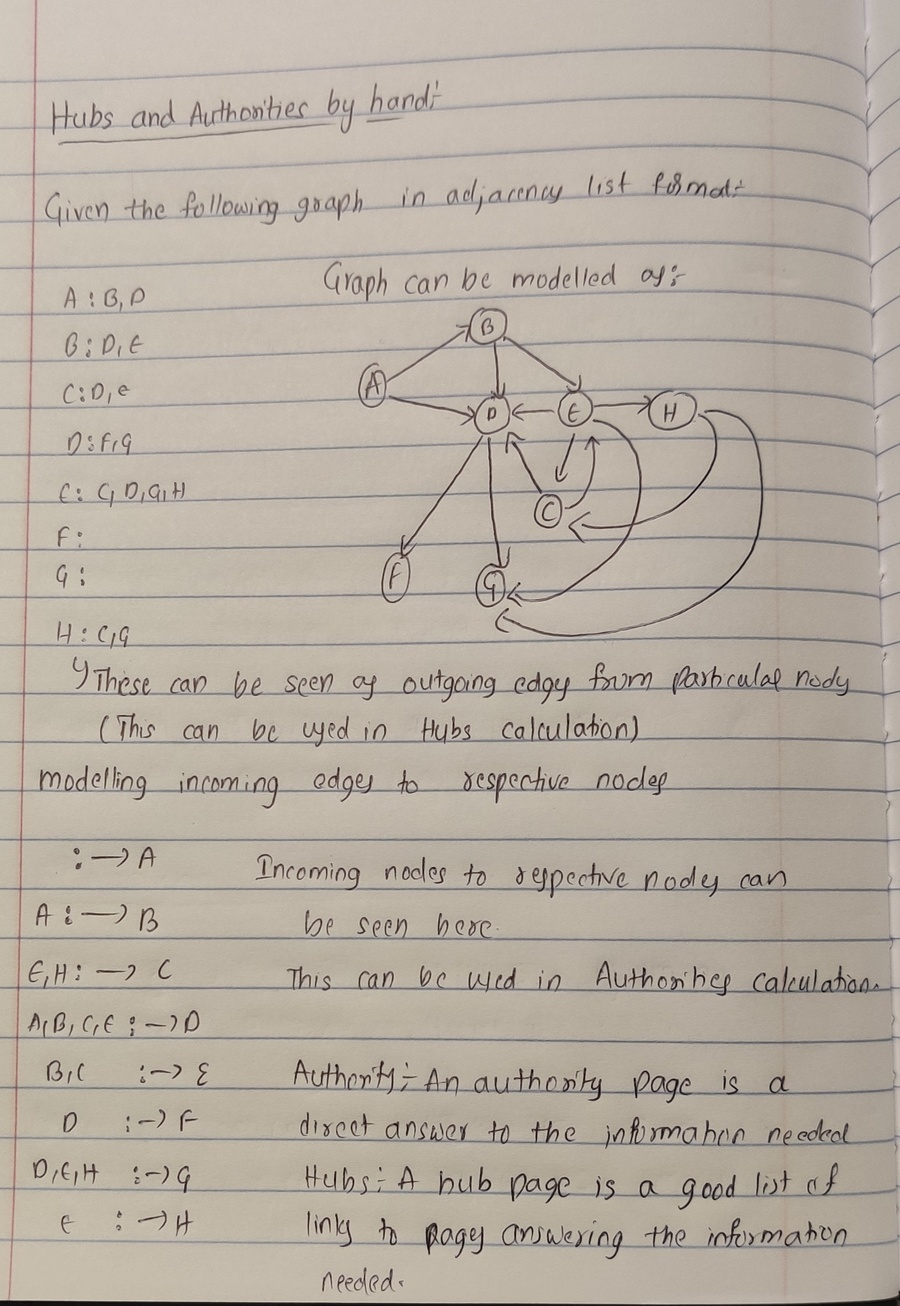

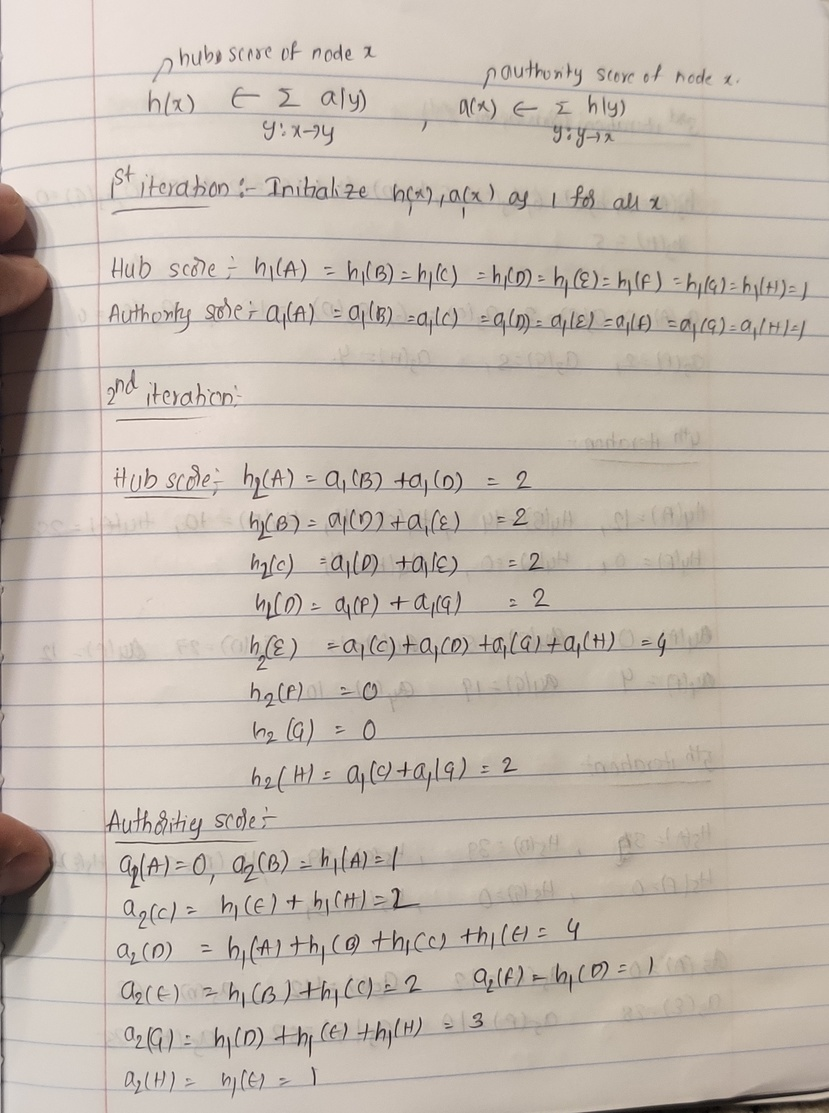

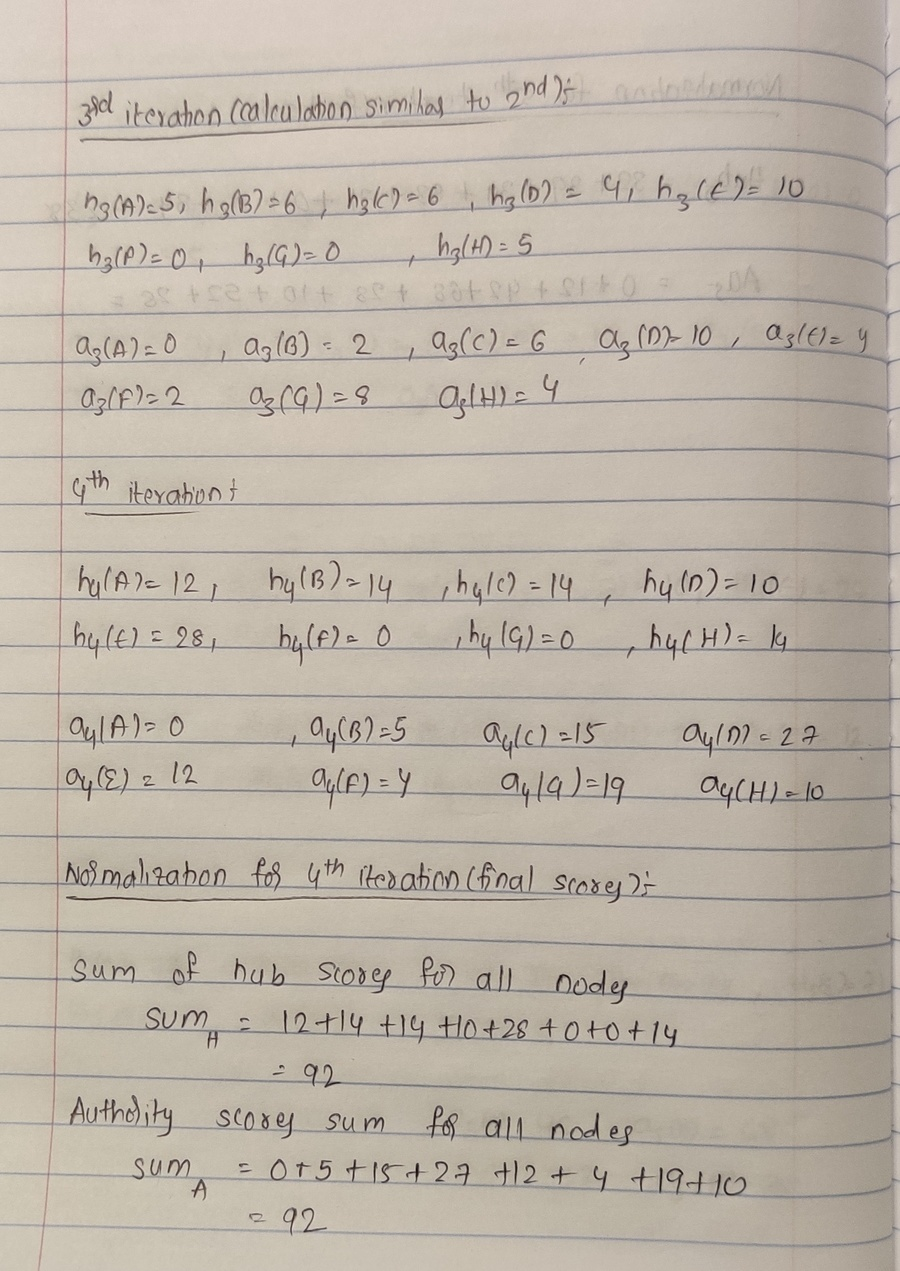

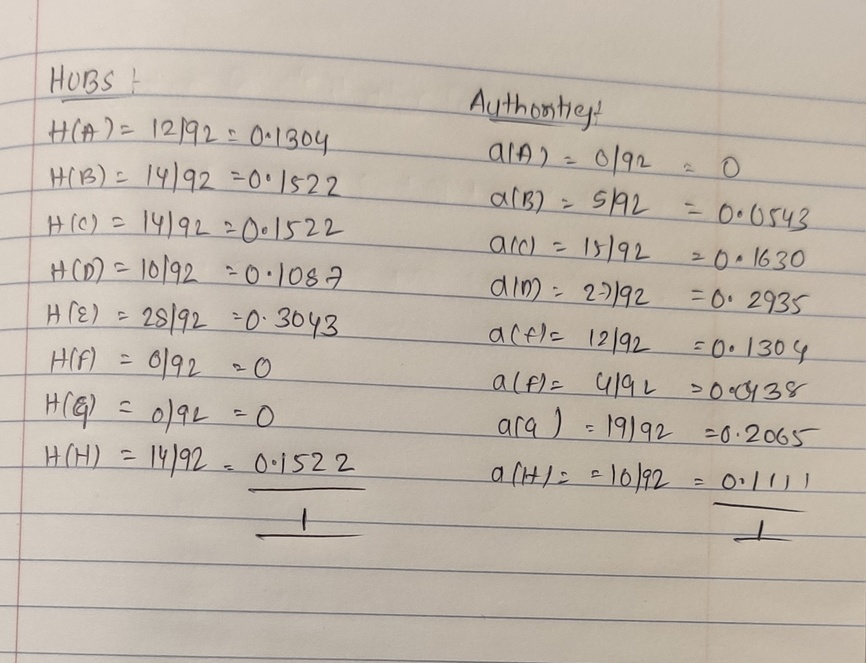



## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


#Exercise 3.1.2 (Page 78)
Compute the Jaccard bag similarity of each pair of the following three bags: {1, 1, 1, 2}, {1, 1, 2, 2, 3}, and {1, 2, 3, 4}

Possible pairs are:

PAIR 1 : {1, 1, 1, 2}, {1, 1, 2, 2, 3}

PAIR 2 :{1, 1, 2, 2, 3}, {1, 2, 3, 4}

PAIR 3 : {1, 1, 1, 2}, {1, 2, 3, 4}

Jaccard bag similarity : |S ∩ T|/|S ∪ T|

Pair 1 :

Union of two sets : {1, 1, 2}, |S ∩ T| = 3

Intersection of two sets  {1, 1, 1, 2, 1, 1, 2, 2, 3}, |S ∩ T| = 9

Jaccard bag similarity for Pair 1 : 3/9 = 1/3

Pair 2 :

Union of two sets : {1, 2, 3}, |S ∩ T| = 3

Intersection of two sets  {1, 1, 2, 2, 3, 1, 2, 3, 4}, |S ∩ T| = 9

Jaccard bag similarity for Pair 1 : 3/9 = 1/3

Pair 3 :

Union of two sets : {1, 2}, |S ∩ T| = 2

Intersection of two sets  {1, 1, 1, 2, 1, 2, 3, 4}, |S ∩ T| = 8

Jaccard bag similarity for Pair 1 : 2/8 = 1/4




#Excercise 3.2.2 (Page 81)

If we use the stop-word-based shingles of Section 3.2.4, and we take the stop words to be all the words of three or fewer letters, then what are the shingles in the first sentence of Section 3.2?

First sentence of section 3.2 :

The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it 

stop-word-based shingles concept of section 3.2.4 :

Defining a shingle to be a stop word followed by the next two words, regardless of whether or not they were stop words, formed a useful set of shingles.

Stop words are defined to be all the words of three of fewer letters

Possible stop words : the, way, to, as, for, of, is, to, set, of, it

Possible shinlges in the given sentence according to section 3.2.4 are: 

1. The most effective

2. way to represent

3. to represent documents

4. as sets for

5. for the purpose

6. the purpose of

7. of identifying lexically

8. is to construct

9. to construct from

10. the document the

11. the set of 

12. set of short

13. of short strings

There are a total of 13 such stop-word-based shingles. 


#Exercise 3.3.3 (Page 90)
Compute the minhash signature for each column if we use the following three hash functions: h1(x) = 2x + 1 mod 6; h2(x) = 3x + 2 mod 6; h3(x)=5x+2 mod6.

Part-a: 

Worked out by hand with clear steps

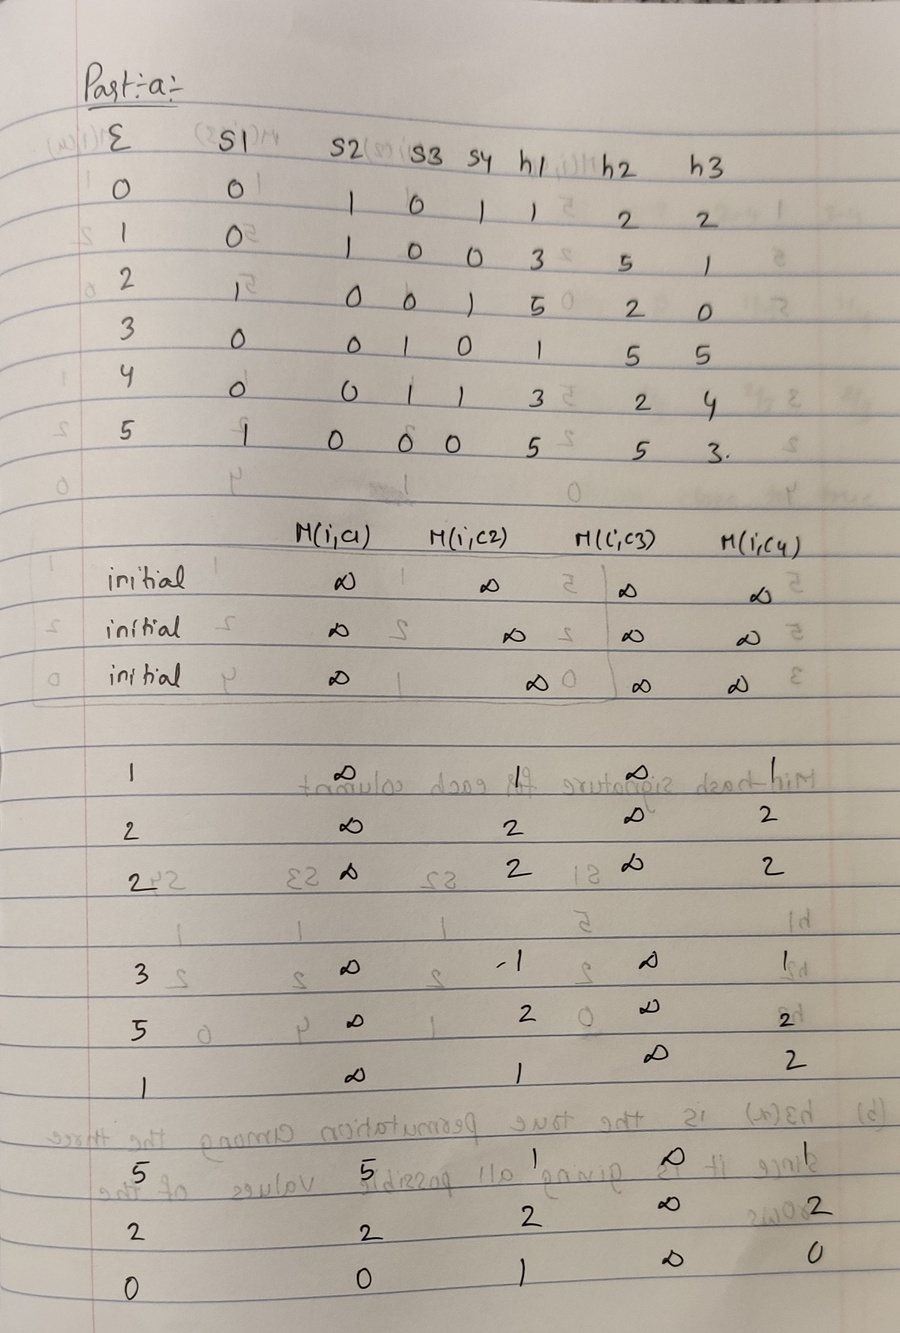

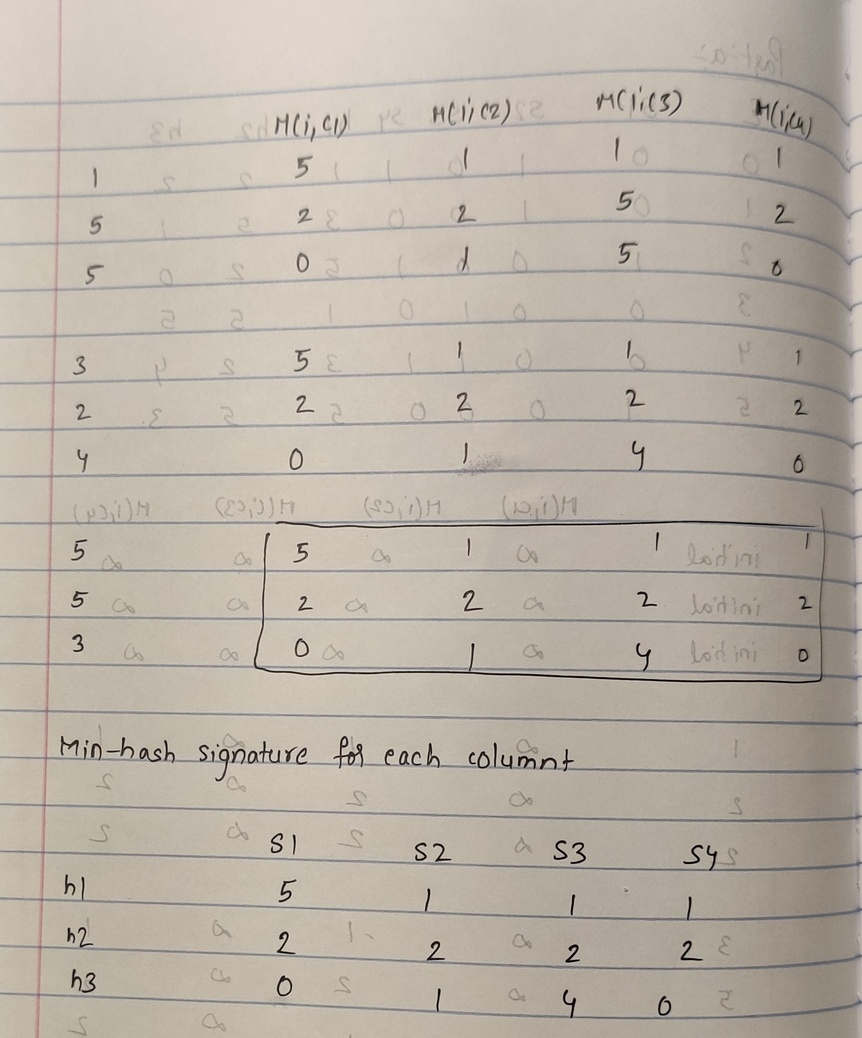

Part b :
 **h3(x) is the true permutation among the three since it is giving all possible values of the rows**

Part C

Part c:
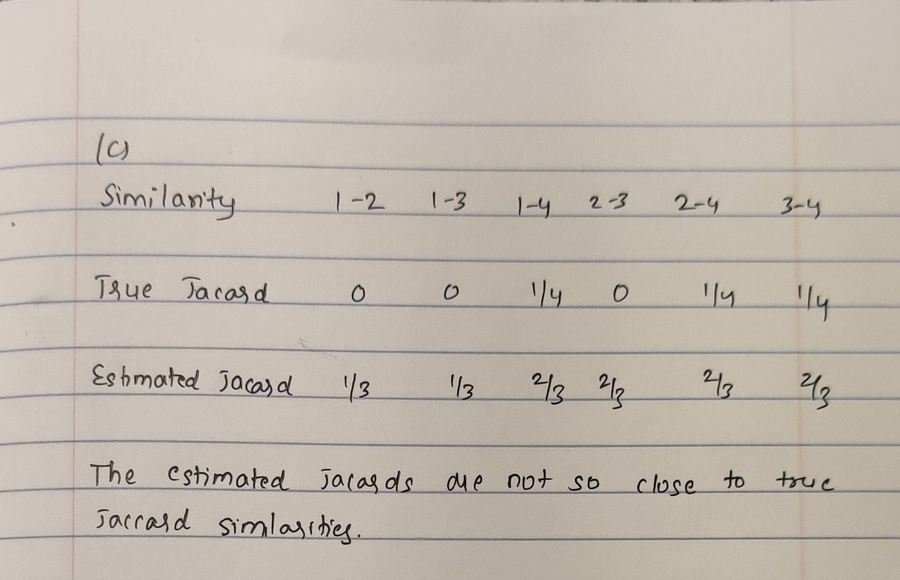

#Exercise 3.4.1 (Page 96)


Text(0, 0.5, '(1 - (1 - s^r)^b)')

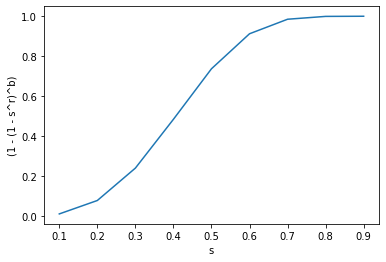

In [31]:
import matplotlib.pyplot as plt
s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
s1= []

for val in s :
  s1.append(1 - (1 - val**3)**10)


plt.plot(s, s1)
plt.xlabel("s")
plt.ylabel("(1 - (1 - s^r)^b)")

Text(0, 0.5, '(1 - (1 - s^r)^b)')

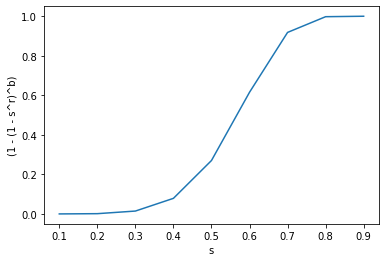

In [32]:
import matplotlib.pyplot as plt
s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
s2= []

for val in s :
  s2.append(1 - (1 - val**6)**20)
  
plt.plot(s, s2)
plt.xlabel("s")
plt.ylabel("(1 - (1 - s^r)^b)")

Text(0, 0.5, '(1 - (1 - s^r)^b)')

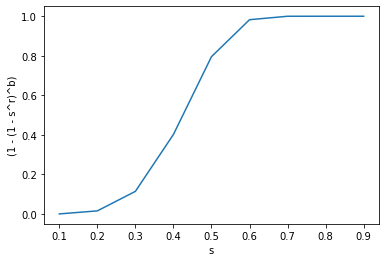

In [33]:
import matplotlib.pyplot as plt
s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
s3 = []

for val in s :
  s3.append(1 - (1 - val**5)**50)


plt.plot(s, s3)
plt.xlabel("s")
plt.ylabel("(1 - (1 - s^r)^b)")


In [22]:
print('The values we get from the s-curve for s = [0.1 to 0.9] r = 3 and b = 10 respectively are : ')
print(s1)
print('The values we get from the s-curve for s = [0.1 to 0.9] r = 6 and b = 20 respectively are : ')
print(s2)
print('The values we get for the s-curve for s = [0.1 to 0.9] r = 5 and b = 50 respectively are : ')
print(s3)

The values we get from the s-curve for s = [0.1 to 0.9] r = 3 and b = 10 respectively are : 
[0.009955119790251765, 0.07718058804273675, 0.23944889319887064, 0.4838707317677322, 0.7369244238361716, 0.9122674753991765, 0.985015105295655, 0.9992340538808936, 0.9999978635491371]
The values we get from the s-curve for s = [0.1 to 0.9] r = 6 and b = 20 respectively are : 
[1.9999810001669616e-05, 0.001279222058761964, 0.014479466504172311, 0.07880932311056232, 0.27018714400947597, 0.6154146360312677, 0.9181859965846741, 0.9977121251546806, 0.9999997398129465]
The values we get for the s-curve for s = [0.1 to 0.9] r = 5 and b = 50 respectively are : 
[0.0004998775195954597, 0.01587519984502117, 0.11453988231042189, 0.4022839522088044, 0.7955506304323648, 0.9825338277068608, 0.9998989958361557, 0.9999999976077777, 1.0]


#Exercise 3.4.2 (Page 96)
For each of the (r,b) pairs in Exercise 3.4.1, compute the threshold, that is, the value of s for which the value of 1−(1−sr)b is exactly 1/2. How does this value compare with the estimate of (1/b)1/r that was suggested in Section 3.4.2?

Required to find the value of s for which 1-(1-s^r)^b is exactly 1/2 for the value of (r,b) pairs

s value from r,b is s = (1 - 0.5^(1/b))^1/r

For Pair 1, r = 3, b = 10

s value is obtained to be 0.406

Estimate of (1/b)^(1/r) is obtained to be 0.464

It is observed that s value is obtained to be 87.5% of the estimate 

For Pair 2, r = 6, b = 20

s value is obtained to be 0.569

Estimate of (1/b)^(1/r) is obtained to be 0.606

It is observed that s value is obtained to be 93.8% of the estimate 

For Pair 3, r = 5, b = 50

s value is obtained to be 0.424

Estimate of (1/b)^(1/r) is obtained to be 0.457

It is observed that s value is obtained to be 92.3% of the estimate 

